# **Background and Context**

Covid-19 is a fast-growing disease that affects human health severely. Patients diagnosed with this condition suffer from lung infections. The medical community has recently released vaccines that have a slower effect in increasing immunity. This virus has impacted various countries\' human health and financial standards.

Deep learning algorithms have recently used image classification to identify medical images. Convolutional Neural Networks (CNN) can be widely utilized to identify COVID-19 to assist radiologists in medical analysis by classifying patients who are healthy, have viral pneumonia, or are affected by COVID using X-ray pictures of the lungs.

## **Objective**
The aim of this project is two folds:

- Build a deep learning model  to differentiate an X-ray image of a normal person from an unhealthy one.

- Build an app using Streamlit for users to make predictions or inference using your model.

### **Data Description**
This dataset contains training set images of 3 classes which are converted into numpy arrays.

The dataset comprises 3 classes:
- COVID-19: The patient who is affected due to covid.

- Viral Pneumonia: This is a viral fever that has similar characteristics to Covid but is not covid.

- Normal- A healthy Person.

The data file names are:
`CovidImages.npy`

`CovidLabels.csv`

Due to the large volume of data, the images were converted to the CovidImages.npy file and the labels are also put into CovidLabels.csv so that you can work on the data/project seamlessly without having to worry about the high data volume.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing the necessary libraries**

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

from keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras import backend
import itertools

## **Reading the dataset**

In [4]:
# Load the image file of the dataset
images = np.load("/content/drive/MyDrive/Assignment/CovidImages.npy")

# Load the labels file of the dataset
labels = pd.read_csv("/content/drive/MyDrive/Assignment/CovidLabels.csv")

In [5]:
np.unique(labels)

array(['Covid', 'Normal', 'Viral Pneumonia'], dtype=object)

In [6]:
labels["Label"].value_counts()

Covid              111
Viral Pneumonia     70
Normal              70
Name: Label, dtype: int64

### Overview of the dataset

Printing the shape of the images and labels

In [7]:
print(images.shape)

print(labels.shape)

(251, 128, 128, 3)
(251, 1)


<b>Converting the BGR images to RGB images.

In [8]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

## Visualizations

In [9]:
def plot_images(images,labels):
  # num_classes=10                                                                  # Number of Classes
  # categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
          plt.tight_layout()
  plt.show()

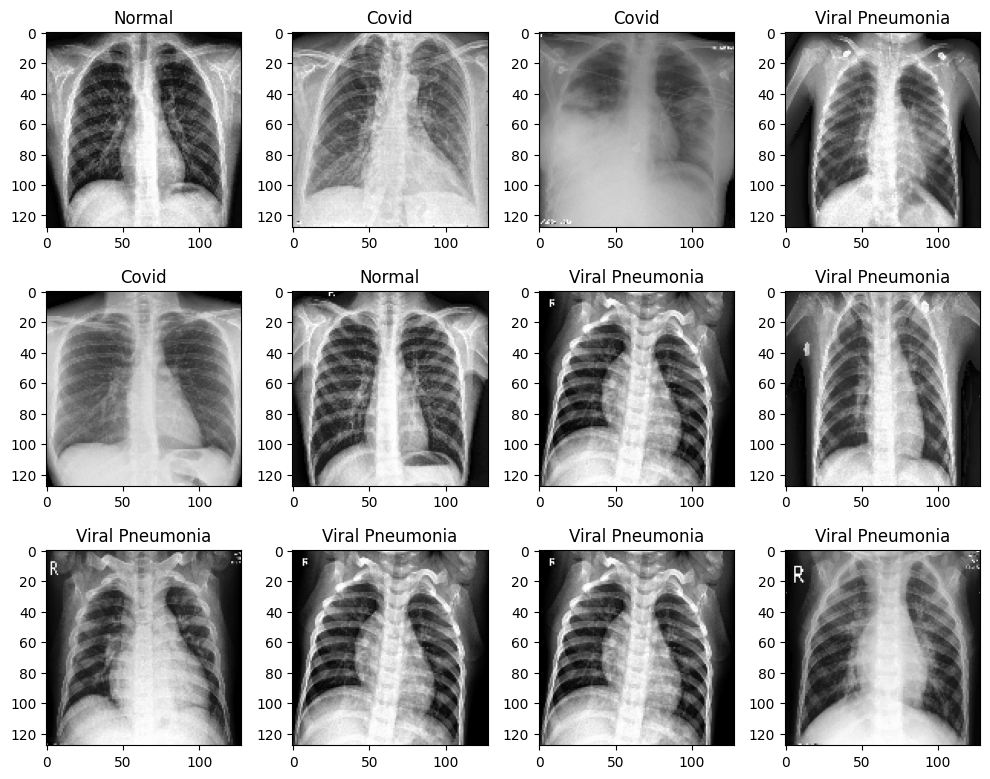

In [10]:
plot_images(images,labels)

<b> Checking for data imbalance

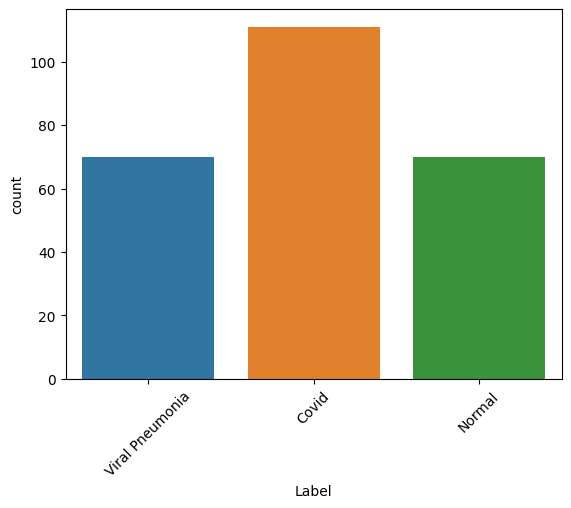

In [11]:
sns.countplot(data = labels, x = "Label")
plt.xticks(rotation=45);

The dataset is not balanced as each classes has different number of images



## **Splitting the dataset**

- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.

- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [12]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [13]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(202, 128, 128, 3) (202, 1)
(23, 128, 128, 3) (23, 1)
(26, 128, 128, 3) (26, 1)


## **Making the data compatible:**

- Convert labels from names to one hot vectors
- Normalizing the values


## Encoding the target labels

In [14]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

#### Data Normalization

Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1**.

In [15]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [16]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [17]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [18]:
def visualize_learning(hist, save_path=None):
    epochs_range = np.arange(1, len(hist.history['loss']) + 1)
    plt.style.use('ggplot')

    # Create a 1x2 grid of plots
    fig, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    # Plotting loss on the left subplot
    loss_axis.plot(epochs_range, hist.history['loss'], 'r--o', label='Train Loss')
    loss_axis.plot(epochs_range, hist.history['val_loss'], 'b--o', label='Validation Loss')
    loss_axis.set_title('Epoch vs. Loss')
    loss_axis.set_xlabel('Epochs')
    loss_axis.set_ylabel('Loss Value')
    loss_axis.legend(loc='upper right')

    # Plotting accuracy on the right subplot
    accuracy_axis.plot(epochs_range, hist.history['accuracy'], 'r--o', label='Train Accuracy')
    accuracy_axis.plot(epochs_range, hist.history['val_accuracy'], 'b--o', label='Validation Accuracy')
    accuracy_axis.set_title('Epoch vs. Accuracy')
    accuracy_axis.set_xlabel('Epochs')
    accuracy_axis.set_ylabel('Accuracy Value')
    accuracy_axis.legend(loc='lower right')

    plt.tight_layout()

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

### **Models Building - Convolutional Neural Network (CNN)and Transfer Learning model (DenseNet 121 Model)**

#### Architecture 1

In [19]:
# define model architecture
base_model = Sequential()

# The Input Layer :
# First convolutional block
base_model.add(Conv2D(64, (3,3), activation = "relu", padding="same", input_shape = (128, 128, 3)))# 32 is filters
base_model.add(MaxPooling2D((2,2)))


# second convolutional block
base_model.add(Conv2D(32, (3,3), activation = "relu"))# 32 is filters
base_model.add(MaxPooling2D((2,2)))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
base_model.add(Flatten())
base_model.add(Dense(16, activation = "relu"))

# The Output Layer :
base_model.add(Dense(3, activation= "softmax"))

In [20]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 16)                4

In [21]:
# define model checkpoint
model_filename = "/content/drive/MyDrive/Assignment/Models/covid_cnn.hdf5"
chkpt = ModelCheckpoint(model_filename, save_best_only = True, verbose = 2)

# define early stopping layer
es = EarlyStopping(patience = 3, monitor="val_loss", mode ="min", verbose = 2)

In [22]:
# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
base_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

In [23]:
# Fit the model on the train data
history = base_model.fit(
            X_train_normalized, y_train_encoded,
            epochs=10,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=2, callbacks =[chkpt, es])

Epoch 1/10

Epoch 1: val_loss improved from inf to 1.09866, saving model to /content/drive/MyDrive/Assignment/Models/covid_cnn.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 - 20s - loss: 1.3338 - accuracy: 0.3762 - val_loss: 1.0987 - val_accuracy: 0.2609 - 20s/epoch - 5s/step
Epoch 2/10

Epoch 2: val_loss improved from 1.09866 to 0.87690, saving model to /content/drive/MyDrive/Assignment/Models/covid_cnn.hdf5
4/4 - 7s - loss: 1.0194 - accuracy: 0.5198 - val_loss: 0.8769 - val_accuracy: 0.7391 - 7s/epoch - 2s/step
Epoch 3/10

Epoch 3: val_loss improved from 0.87690 to 0.63042, saving model to /content/drive/MyDrive/Assignment/Models/covid_cnn.hdf5
4/4 - 8s - loss: 0.8001 - accuracy: 0.7475 - val_loss: 0.6304 - val_accuracy: 0.6957 - 8s/epoch - 2s/step
Epoch 4/10

Epoch 4: val_loss improved from 0.63042 to 0.40870, saving model to /content/drive/MyDrive/Assignment/Models/covid_cnn.hdf5
4/4 - 6s - loss: 0.5048 - accuracy: 0.8218 - val_loss: 0.4087 - val_accuracy: 0.8696 - 6s/epoch - 2s/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.40870
4/4 - 9s - loss: 0.3182 - accuracy: 0.8663 - val_loss: 0.4283 - val_accuracy: 0.7826 - 9s/epoch - 2s/step
E

**Evaluating the model on test data**

In [24]:
evaluate = base_model.evaluate(X_test_normalized, y_test_encoded, verbose=1)

1/1 [==============================] - 0s 231ms/step - loss: 0.1716 - accuracy: 0.9231


In [25]:
# Create a DataFrame from the history object
history_df = pd.DataFrame(history.history)

# Print the DataFrame
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.333759,0.376238,1.098662,0.260870
1,1.019445,0.519802,0.876897,0.739130
2,0.800064,0.747525,0.630419,0.695652
3,0.504762,0.821782,0.408697,0.869565
4,0.318201,0.866337,0.428321,0.782609
5,0.296394,0.896040,0.383671,0.869565
6,0.207209,0.900990,0.212142,0.913043
7,0.185085,0.930693,0.309576,0.913043
8,0.173206,0.920792,0.167058,0.956522
9,0.160058,0.940594,0.176573,0.956522


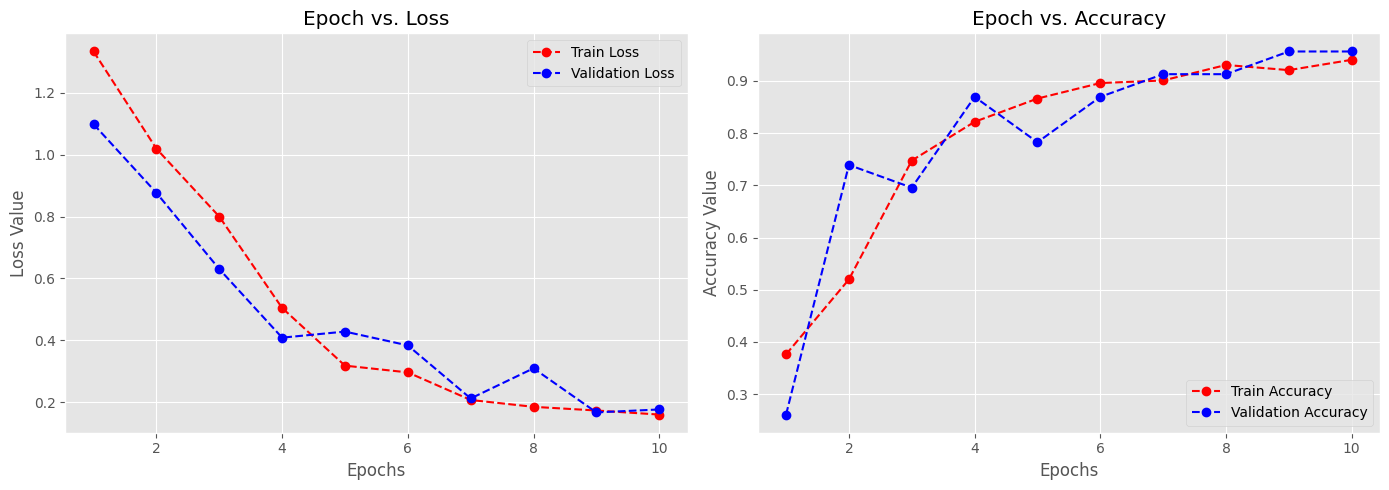

In [26]:
# Plot the accuracy and loss curves
visualize_learning(history, save_path='/content/drive/MyDrive/Assignment/learning curves/base_model_learning_curves.png')

### Observations

The Base model


In [27]:
# Here we would get the output as probablities for each category
y_pred=base_model.predict(X_test_normalized)

1/1 [==============================] - 0s 306ms/step


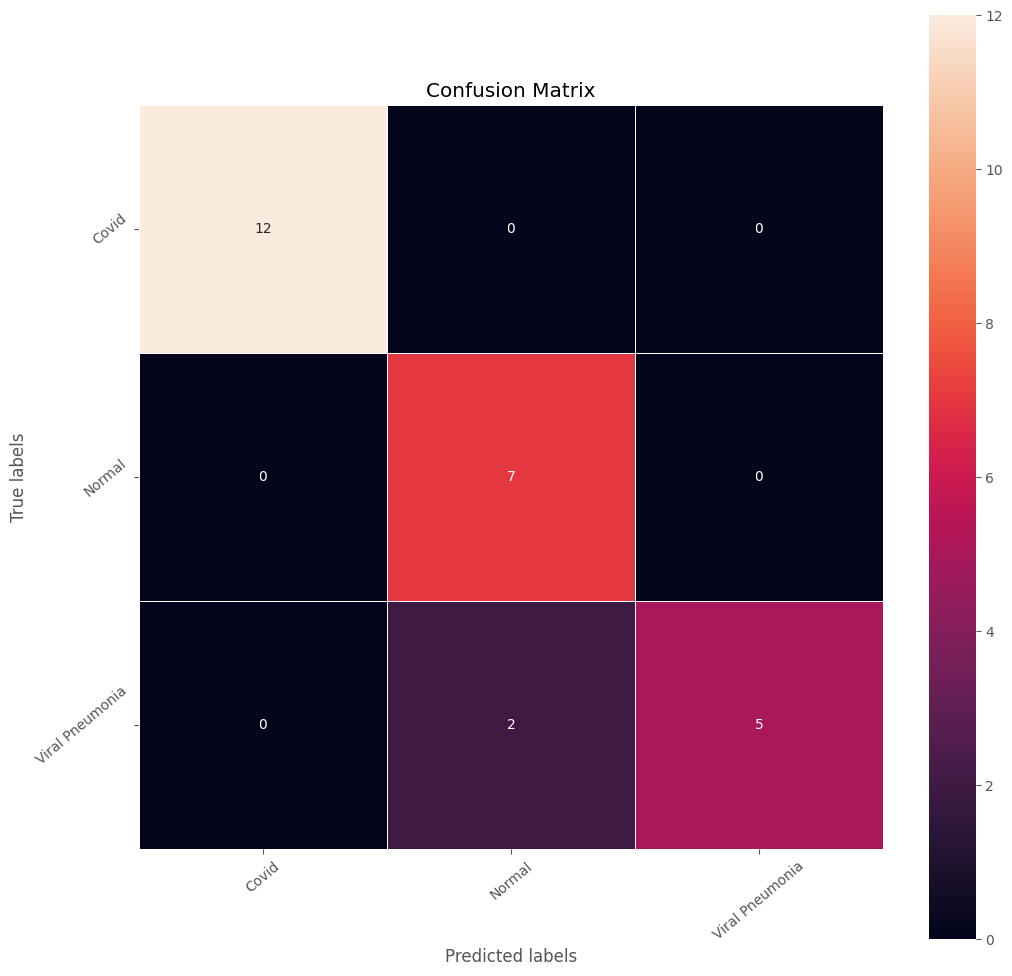

In [28]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=40)
plt.show()

### Observations
- According to the confusion matrix, Viral Pneumonia had 2 cases of misclassification being represented as Normal.

- We will use Transfer Learning (Densenet 121) to cross check if we can arise at a better model to build our applications.

In [29]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Transfer Learning using Densenet

- Let's try again, but this time, we will be using the idea of **Transfer Learning**. We will be loading a pre-built architecture - **DenseNet 121**, which was trained on the ImageNet dataset.

- For training DenseNet 121, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.

In [30]:
# Define DenseNet model
densenet_model = DenseNet121(include_top = False, input_shape = (128, 128, 3), weights = "imagenet")
densenet_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 134, 134, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1/conv[0][0]']

In [31]:
# Making all the layers of the Densenet model non-trainable. i.e. freezing them
for layer in densenet_model.layers:
  layer.trainable = False

In [32]:
# define the architecture
densemodel = Sequential()

# Adding the convolutional part of the Densenet model from above
densemodel.add(densenet_model)

# Flattening the output of the Densenet model because it is from a convolutional layer
densemodel.add(Flatten())

# Adding dense layers
densemodel.add(Dense(64, activation='relu'))
# Adding droput layer with 0.2 dropout rate
densemodel.add(Dropout(0.2))

densemodel.add(Dense(32, activation='relu'))
# Adding droput layer with 0.2 dropout rate

# add our FCN
densemodel.add(Dense(16, activation = "relu"))

# Final layer
densemodel.add(Dense(3, activation = "softmax"))

In [33]:
densemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 64)                1048640   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 3)                 5

In [34]:
# Compile the model
densemodel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=["accuracy"])

In [35]:
# define model checkpoint
model_filename = "/content/drive/MyDrive/Assignment/Models/covid_dense.hdf5"
chkpt1 = ModelCheckpoint(model_filename, save_best_only = True, verbose = 2)

# define early stopping layer
es = EarlyStopping(patience = 3, monitor="val_loss", mode ="min", verbose = 2)

In [36]:
# Epochs
epochs = 10
# Batch size
batch_size = 64

#  Fit the model on the train data
history = densemodel.fit(X_train_normalized, y_train_encoded,
                         batch_size=batch_size,
                         shuffle=False,
                         epochs=epochs,
                         steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                         validation_data=(X_val_normalized, y_val_encoded),
                         verbose=1, callbacks=[chkpt1, es])

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 3.2106 - accuracy: 0.3698
Epoch 1: val_loss improved from inf to 1.48221, saving model to /content/drive/MyDrive/Assignment/Models/covid_dense.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 27s 7s/step - loss: 3.2106 - accuracy: 0.3698 - val_loss: 1.4822 - val_accuracy: 0.4783
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 1.4390 - accuracy: 0.5725
Epoch 2: val_loss improved from 1.48221 to 0.93938, saving model to /content/drive/MyDrive/Assignment/Models/covid_dense.hdf5
3/3 [==============================] - 11s 5s/step - loss: 1.4390 - accuracy: 0.5725 - val_loss: 0.9394 - val_accuracy: 0.6087
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 1.3011 - accuracy: 0.6739
Epoch 3: val_loss did not improve from 0.93938
3/3 [==============================] - 10s 4s/step - loss: 1.3011 - accuracy: 0.6739 - val_loss: 1.4465 - val_accuracy: 0.6957
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.8876 - accuracy: 0.7754
Epoch 4: val_loss improved from 0.93938 to 0.61865, saving model to /content/drive/MyDrive/Assignment/Models/covid_dense.hdf5
3/3 [==============================] - 9s 3s

In [37]:
evaluate = densemodel.evaluate(X_test_normalized, y_test_encoded, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.3790 - accuracy: 0.7692


In [38]:
# Create a DataFrame from the history object
history_df = pd.DataFrame(history.history)

# Print the DataFrame
history_df

,loss,accuracy,val_loss,val_accuracy
0,3.210639,0.369792,1.482210,0.478261
1,1.438952,0.572464,0.939378,0.608696
2,1.301112,0.673913,1.446537,0.695652
3,0.887633,0.775362,0.618651,0.869565
4,0.679701,0.817708,0.607343,0.913043
5,0.510687,0.840580,0.825660,0.869565
6,0.534259,0.818841,0.955466,0.826087
7,0.289142,0.905797,0.901319,0.869565


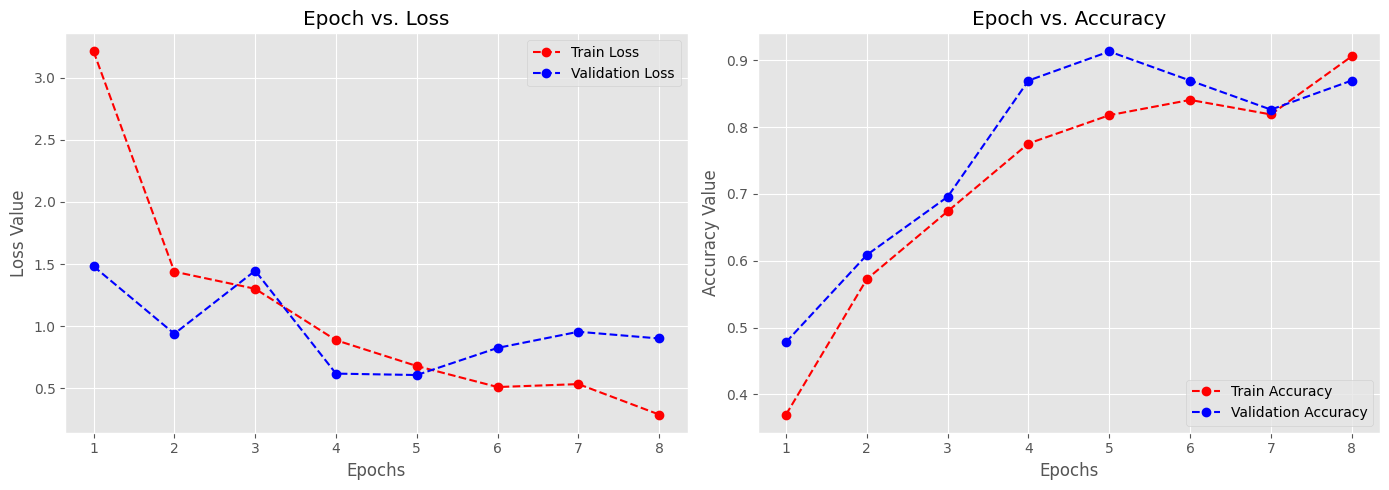

In [39]:
# Plot loss and accuracy
visualize_learning(history, save_path='/content/drive/MyDrive/Assignment/learning curves/densemodel_learning_curves.png')

In [40]:
# Generate predictions for the test set
y_pred = densemodel.predict(X_test_normalized)


1/1 [==============================] - 3s 3s/step


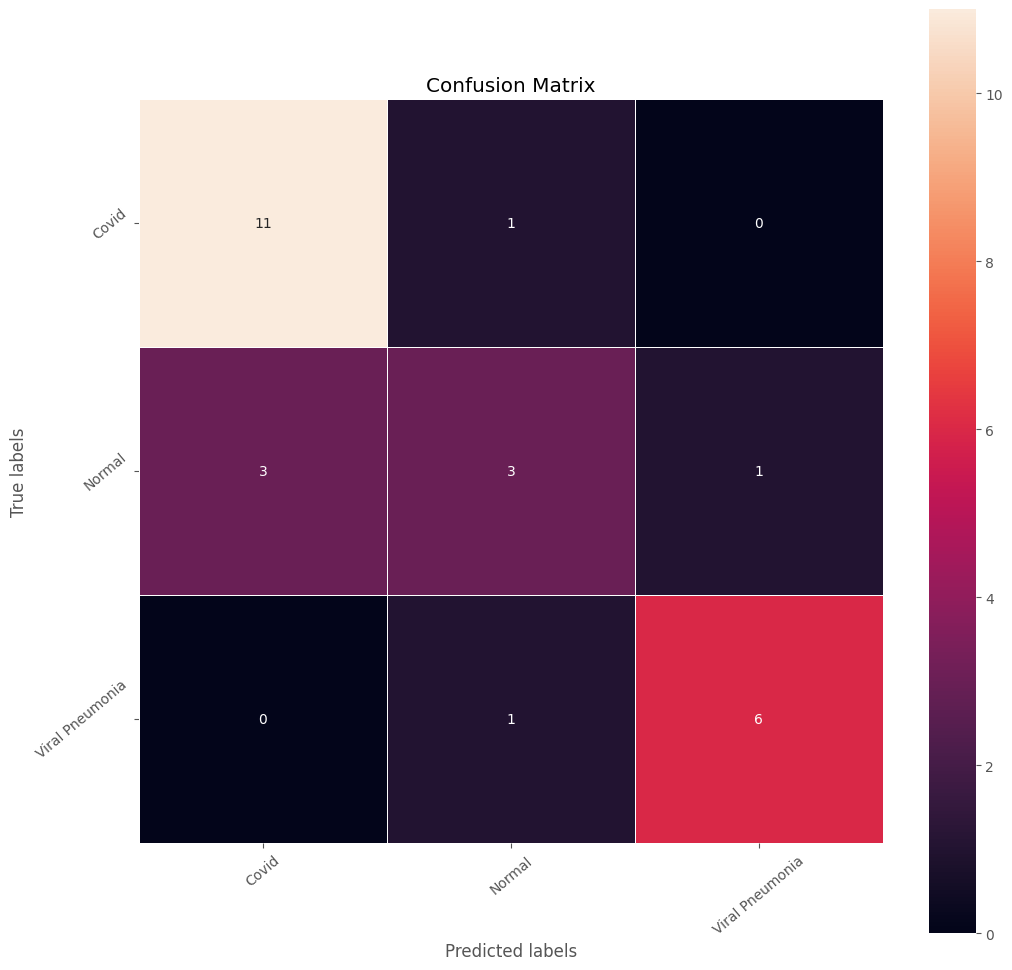

In [41]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=40)
plt.show()

# Observation

- There were more misclassification with the Densenet Model as with prediction Normal against covid and just one misclassification with Viral Pneumonia against Normal.

# Visual Predictions

1/1 [==============================] - 0s 128ms/step


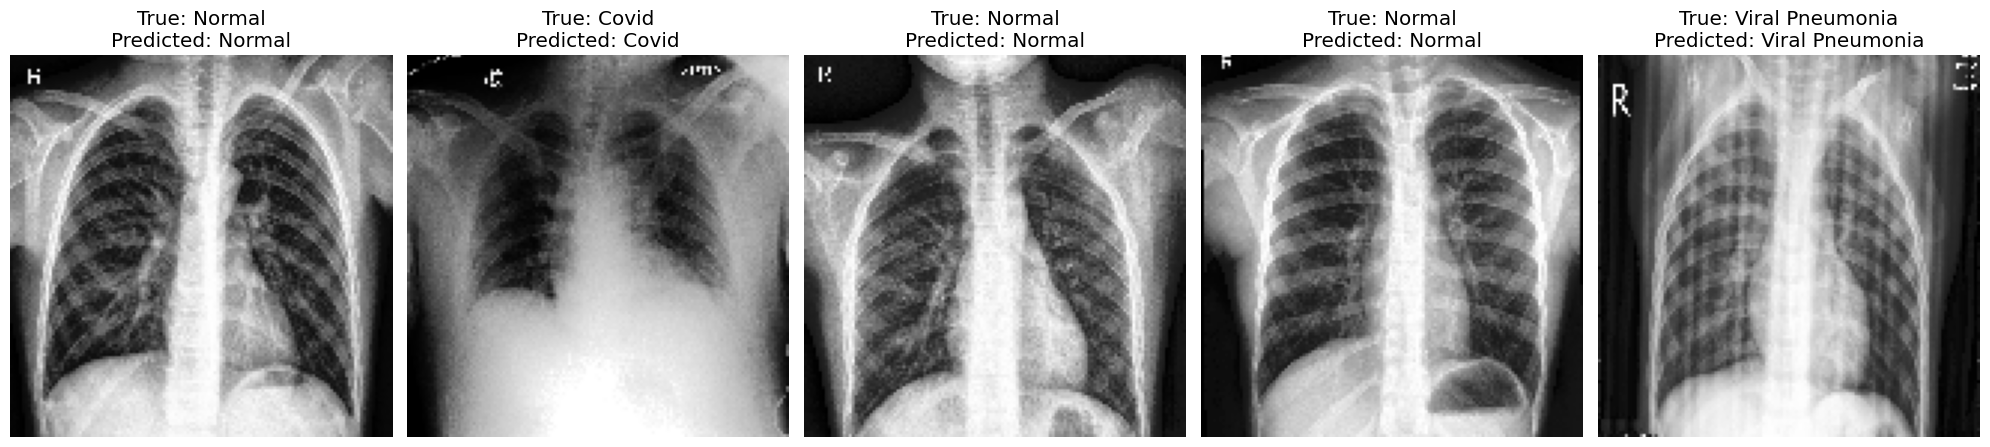

In [42]:
def plot_predictions(model, X, y, class_names, num_images=5):
    """
    model: The trained model.
    X: Input data (images) in BGR format.
    y: True labels in one-hot encoded format.
    class_names: List of class names.
    num_images: Number of images to visualize.
    """
    # Randomly select num_images indices
    random_indices = random.sample(range(X.shape[0]), num_images)

    # Getting predictions for the randomly selected images
    selected_X = X[random_indices]
    selected_y = y[random_indices]
    predictions = model.predict(selected_X)
    pred_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(selected_y, axis=1)

    # Plotting
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i, ax in enumerate(axes):
        # Convert BGR to RGB
        rgb_image = cv2.cvtColor(selected_X[i], cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.set_title(f"True: {class_names[true_labels[i]]}\nPredicted: {class_names[pred_labels[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define class names
class_names = ['Covid', 'Normal', 'Viral Pneumonia']

# Assuming you have images in X_test (BGR format) and one-hot encoded labels in y_test_encoded.
# You can specify the number of images to visualize with num_images.
num_images_to_visualize = 5

# Plot predictions with randomly selected images
plot_predictions(base_model, X_test, y_test_encoded, class_names, num_images=num_images_to_visualize)


1/1 [==============================] - 2s 2s/step


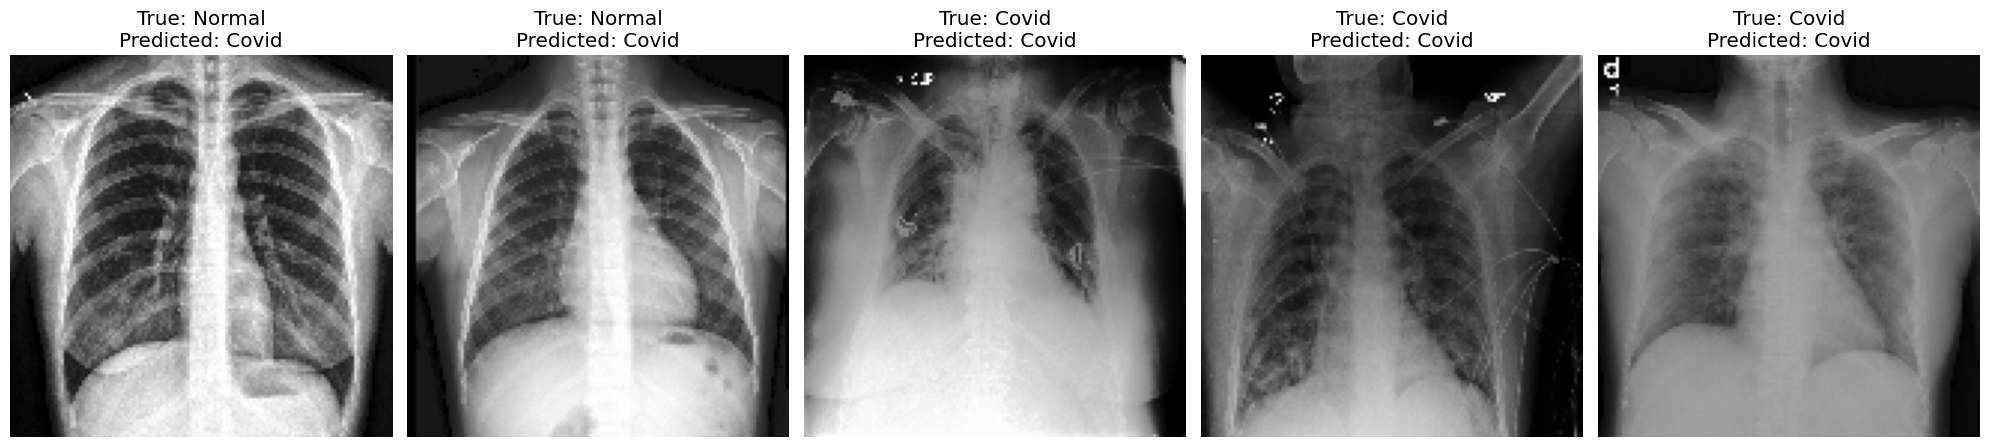

In [43]:
# Plot predictions
plot_predictions(densemodel, X_test, y_test_encoded, class_names, num_images=num_images_to_visualize)

## ** Observation**

We notice that Base Model did better and predicted better than the Densenet Model. We will go ahead and use the Base model to build our application for Covid 19 Predictions.

### Comparing the model performance

In [45]:
pd.DataFrame({'Models':['Base CNN Model','Transfer Learning Model( Densenet Model)'],'Train Accuracy':['94.06%','90.58%'],'Validation Accuracy':['95.65%','86.96%'],'Test Accuracy':['92.31%','76.92%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,94.06%,95.65%,92.31%
1,Transfer Learning Model( Densenet Model),90.58%,86.96%,76.92%
